In [1]:
import os
from collections import namedtuple

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax.experimental.ode import odeint, vjp_odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [2]:
NB_DAYS_BEFORE_TEN_DEATHS = 30

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

country = 'France'
subset = full.loc[country]
deaths_subset = subset.loc[ix[:, 'total_deaths']]

pop_country = populations_country.loc[country]

ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
begin_date = ten_deaths_date - pd.Timedelta(NB_DAYS_BEFORE_TEN_DEATHS, unit='days')

total_deaths = deaths_subset.loc[begin_date:].values
# data = total_deaths / pop_country

times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

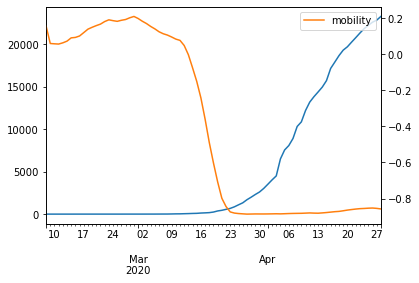

In [3]:
mobility = subset.loc[ix[:, 'transit']].rename('mobility')
mobility = (mobility
            .reindex(deaths_subset.loc[begin_date:].index)
            .fillna(method='ffill')
            .fillna(method='bfill')
            #.fillna(mobility.iloc[-1])
            .rolling('7d').mean())

to_plot = pd.DataFrame({'deaths': total_deaths}, index=times).join(mobility)
to_plot['deaths'].plot(label='deaths')
to_plot['mobility'].plot(secondary_y=True)
plt.legend() ;

## France data
This data is rich, because we have the number of hospitalized and critical.

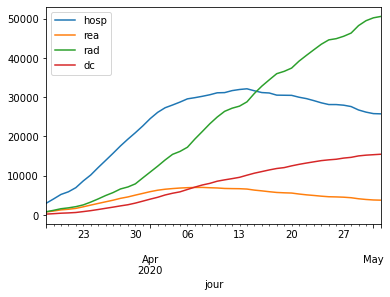

In [4]:
hosp = (pd.read_csv('donnees-hospitalieres-covid19-2020-05-02-19h00.csv', sep=';', parse_dates=['jour'])
        .loc[lambda f: f['sexe'] == 0]
        .groupby('jour')
        .sum()
        .drop('sexe', axis=1))

hosp_indexed = hosp.reindex(times).fillna(0)
hosp.plot() ;

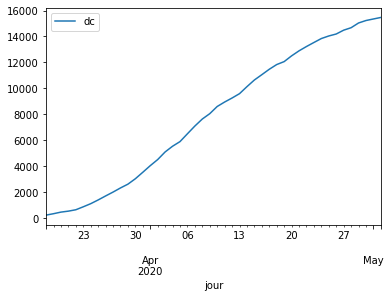

In [5]:
hosp.dc.plot()
plt.legend() ;

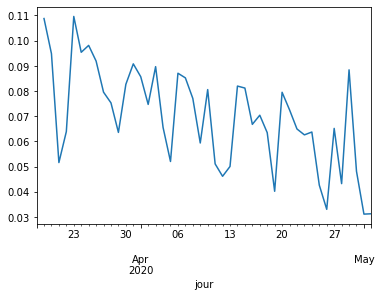

In [6]:
hosp.eval('dc.diff() / rea').plot() ;

# Model

https://www.kaggle.com/anjum48/seir-hcd-model

## Prior choice

We use France's Covid data, that includes the number of critical, deceased, hospitalized (and recovered).

In [7]:
Params = namedtuple('Params', 
                    ['r0', 'r1', 
                     't_inc', 't_inf', 't_hosp', 't_crit', 
                     'm_a', 'c_a', 'f_a']
                   )

PRIOR_MEANS = Params(r0=3.3,
              r1=0.5, 
              t_inc=5.1, 
              t_inf=2.79, 
              t_hosp=5.14, 
              t_crit=5., 
              m_a=0.85, 
              c_a=0.2, 
              f_a=0.33)

BUMP_CRITICAL = abs(hosp_indexed['rea'].diff().min()) + 1
BUMP_HOSP = abs(hosp_indexed['hosp'].diff().min()) + 1

## SEIR-HCD model

In [50]:
def build_my_odeint(mobility_data, rtol=1e-5, atol=1e-9, mxstep=500):
    """
    code based on jax.experimental.ode.build_ode to make it work with mobility data
    """
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]

        int_t = np.array([t]).astype(int)[0]
        rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]

        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])

    ct_odeint = jax.custom_transforms(
      lambda y0, t, *args: odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep))

    v = lambda y0, t, *args: vjp_odeint(dz_dt, y0, t, *args, rtol=rtol, atol=atol, mxstep=mxstep)
    jax.defvjp_all(ct_odeint, v)

    return jax.jit(ct_odeint)

In [11]:
mobility_data = np.asarray(mobility.to_numpy())

# integrator
seirhcd_int = build_my_odeint(mobility_data)

## Bayesian model

In [97]:
def reparametrize_beta(mean, sample_size):
#     v = numpyro.sample(f'sample_size_{i}', dist.Gamma(*reparametrize_gamma(10., 5)))
    alpha = mean * sample_size
    beta = (1 - mean) * sample_size
    return alpha, beta 

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

In [98]:
a = np.array([1, 2, 3])
np.min(np.stack([a, np.array([4, 5, 6])]), axis=0)

DeviceArray([1, 2, 3], dtype=int64)

In [133]:
def diff_pop(cumulative, pop_country):
    daily = np.hstack((np.array([0.]), np.diff(cumulative * pop_country)))
    daily += 1
    return daily

def make_target_dist(psi_h, psi_c, psi, 
                     daily_hosp, daily_critical, daily_deaths, 
                     bump_hosp, bump_critical):
    
    target_dist = dist.GammaPoisson(
                   np.array([psi_h, psi_c, psi]),
                   rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                  psi_c / (daily_critical + bump_critical), 
                                  psi / daily_deaths]
                                ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])
    return reloc_target_dist

def model(seirhcd_int, N, y=None, compartments='d'):
#     tau = numpyro.sample('tau', dist.Exponential(0.03))
    i_init = numpyro.sample('i_init', 
                            dist.Gamma(*reparametrize_gamma(50, 25.))
#                             dist.Exponential(1. / tau)
                           )
#     i_init = numpyro.sample('i_init', )
    i_init /= pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, PRIOR_MEANS.r0, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0, PRIOR_MEANS.r1, kappa1))
    
#     t_delta = numpyro.sample('t_delta', dist.Gamma(*reparametrize_gamma(3., 1.)))
#     t_delta = int(np.floor(t_delta))
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inc, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_inf, 3.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_hosp, 3.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(PRIOR_MEANS.t_crit, 3.)))
    
#     sample_size_m = numpyro.sample('sample_size_m', dist.Gamma(*reparametrize_gamma(7., 2)))
#     sample_size_c = numpyro.sample('sample_size_c', dist.Gamma(*reparametrize_gamma(7., 2)))
#     sample_size_f = numpyro.sample('sample_size_f', dist.Gamma(*reparametrize_gamma(7., 2)))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.m_a, 5)))
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.c_a, 5)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(PRIOR_MEANS.f_a, 5)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    z = seirhcd_int(z_init, ts, *params)
    
    daily_deaths = diff_pop(z[:, -1], pop_country)

    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
    if compartments == 'd':
        numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

    elif compartments == 'hcd':
        daily_hosp = diff_pop(z[:, -3], pop_country)
        daily_critical = diff_pop(z[:, -2], pop_country)

        hosp = z[:, -3] * pop_country
        critical = z[:, -2] * pop_country

        hosp_m1 = np.hstack(([0.],  hosp[:-1]))
        critical_m1 = np.hstack(([0.],  critical[:-1]))

        bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
        bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        
        target_dist = make_target_dist(psi_h, psi_c, psi, 
                                       daily_hosp, daily_critical, daily_deaths, 
                                       bump_hosp, bump_critical)
        
        numpyro.sample('y', target_dist, obs=y)

        # second attempt : use Truncated Normal for hosp and crit
#         true_hosp = y[:, -3] if y is not None else None
#         true_critical = y[:, -2] if y is not None else None
#         true_deceased = y[:, -1] if y is not None else None
        
#         sigma_h = numpyro.sample('sigma_h', dist.Exponential(1.))
#         sigma_c = numpyro.sample('sigma_c', dist.Exponential(1.))

#         numpyro.sample('hosp', dist.TruncatedNormal(0, hosp, sigma_h), obs=true_hosp)
#         numpyro.sample('critical', dist.TruncatedNormal(0, critical, sigma_c), obs=true_critical)
#         numpyro.sample('deceased', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=true_deceased)
        
    # third attempt: sample increase and decrease
#         i = z[:, 3]
#         h = z[:, -3]
#         c = z[:, -2]

#         dh_plus = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit
#         dh_plus *= pop_country
#         dh_plus += 1
        
#         dh_minus = h / t_hosp
#         dh_minus *= pop_country
#         dh_minus += 1
        
#         dc_plus = c_a * h / t_hosp
#         dc_plus *= pop_country
#         dc_plus += 1
        
#         dc_minus = c / t_crit
#         dc_minus *= pop_country
#         dc_minus += 1
        
#         numpyro.sample('dh_plus', dist.GammaPoisson(psi_h1, psi_h1 / dh_plus)) + numpyro.sample('dh_minus', dist.GammaPoisson(psi_h2, psi_h2 / dh_minus))
        
#         numpyro.sample('dc_plus', dist.GammaPoisson(psi_c1, psi_c1/dc_plus))
#         numpyro.sample('dc_minus', dist.GammaPoisson(psi_c2, psi_c2 / dc_minus))

## Running MCMC

In [156]:
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            1000, 1000, num_chains=NUM_CHAINS, progress_bar=True)

In [157]:
# # To use for D only, no H nor C
# daily_deaths_true = np.hstack((np.array([0.]), np.diff(hosp_indexed['dc'].to_numpy())))
# mcmc.run(PRNGKey(0), seirhcd_int, 
#          N=daily_deaths_true.shape[0], 
#          y=daily_deaths_true + 1, 
#          compartments='d')
# mcmc.print_summary()

(81, 3)


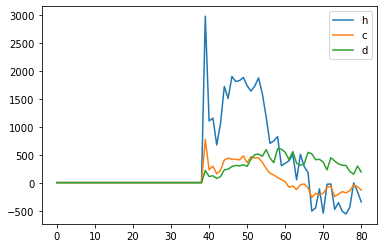

In [158]:
daily_critical = np.hstack((np.array([0.]), np.diff(hosp_indexed['rea'].to_numpy())))
daily_hosp = np.hstack((np.array([0.]), np.diff(hosp_indexed['hosp'].to_numpy())))

data = np.stack([daily_hosp, daily_critical, daily_deaths_true]).T + 1
# data = np.stack([hosp_indexed['hosp'].to_numpy(), hosp_indexed['rea'].to_numpy(), daily_deaths_true + 1]).T
print(data.shape)

df = pd.DataFrame(data)
df.columns = 'h c d'.split()
df.plot() ;

In [ ]:
# H, C and D inference
mcmc.run(PRNGKey(1), seirhcd_int, 
         N=data.shape[0], 
         y=data, 
         compartments='hcd')
mcmc.print_summary()

## Result visualization

In [ ]:
def plot_compartment_results(mu, pi, y_true, times):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

# # Control for HCD params
def plot_hcd_results(mu, pi, data, daily_deaths, times):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -1], pi[:, :, -1], daily_deaths, times)
    plt.title('Daily deaths')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(np.cumsum(mu[:, -1]), pi[:, :, -1], np.cumsum(daily_deaths), times)
    plt.title('Cumulated deaths')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -2], pi[:, :, -2], data[:, -2], times)
    plt.title('Critical')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -3], pi[:, :, -3], data[:, -3], times)
    plt.title('Hospitalized')


In [ ]:
def compute_mu_pi_2(y_pred):
    pop_pred = np.stack([y_pred['hosp'], y_pred['critical'], y_pred['deceased']]).T
    mu = np.mean(pop_pred, 1)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 1)
    return mu, pi

def compute_mu_pi(y_pred):
    pop_pred = y_pred['y']
    mu = np.mean(pop_pred, 0)
    pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)
    return mu, pi

In [ ]:
predictive = Predictive(model, mcmc.get_samples())
y_pred = predictive(PRNGKey(2), seirhcd_int, N=daily_deaths_true.shape[0], compartments='hcd')

In [ ]:
mu, pi = compute_mu_pi(y_pred)

In [ ]:
plot_hcd_results(mu, pi, data, daily_deaths_true, times)
plt.tight_layout()

In [ ]:
inference_data = az.from_numpyro(mcmc)

az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
plt.grid()
az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
plt.grid()
az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
plt.grid()
# az.plot_forest(inference_data, var_names=['t_lim'], figsize=(9, 1))

In [ ]:
az.plot_trace(inference_data) ;

## Running the compartment model

In [ ]:
def run_sim_samples(integrator, samples):
    ts = np.arange(float(data.shape[0]))
    res = []
    for i in range(samples['c_a'].shape[0]):
        post_params = dict()
        for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a'.split(', '):
            post_params[param] = samples[param][i]
    #         post_params[param] = inference_data.posterior[param].values[0, -1]

        i_init = samples['i_init'][i]
        i_init /= pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        args = post_params.values()

        sim_res = integrator(z_init, ts, *args)
        res.append(sim_res)

    res = np.stack(res)
    return res

In [ ]:
def plot_compartment(pred_data, true_data):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(times, np.mean(pred_data, axis=0) * pop_country, label='pred')
    plt.plot(times, true_data, label='true')
    plt.fill_between(times, pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

In [ ]:
def plot_hcd(res, hosp_indexed):

    plt.subplots()
    plot_compartment(res[:, :, -3], hosp_indexed['hosp'].to_numpy())
    plt.title('hospitalized')

    plt.subplots()
    plot_compartment(res[:, :, -2], hosp_indexed['rea'].to_numpy())
    plt.title('critical')

    
    plt.subplots()
    plot_compartment(res[:, :, -1], hosp_indexed['dc'].to_numpy())
    plt.title('deaths')
    
def plot_seir(res):
    plt.subplots()
    plot_compartment(res[:, :, 0], np.zeros(res.shape[1]))
    plt.title('susceptible')

    plt.subplots()
    plot_compartment(res[:, :, 1], np.zeros(res.shape[1]))
    plt.title('exposed')

    plt.subplots()
    plot_compartment(res[:, :, 2], np.zeros(res.shape[1]))
    plt.title('infected')
    
    plt.subplots()
    plot_compartment(res[:, :, 3], np.zeros(res.shape[1]))
    plt.title('recovered')


In [ ]:
samples = mcmc.get_samples()
# pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])

### True mobility

In [ ]:
res = run_sim_samples(seirhcd_int, samples)

In [ ]:
plot_seir(res)
plot_hcd(res, hosp_indexed)

### Fake mobility

In [ ]:
mobility_fake = np.zeros(mobility_data.shape[0])
seirhcd_int_zeros = build_my_odeint(mobility_fake)
res_fake = run_sim_samples(seirhcd_int_zeros, samples)

In [ ]:
plot_seir(res_fake)
plot_hcd(res_fake, hosp_indexed)

## Running SEIR-HCD model with prior means

### True mobility

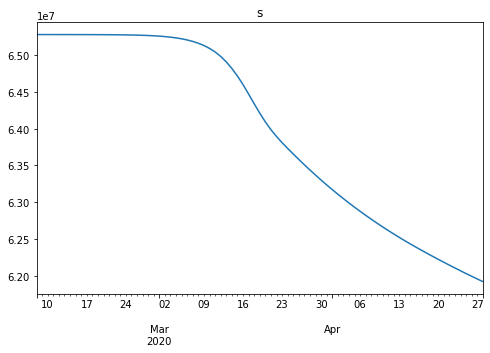

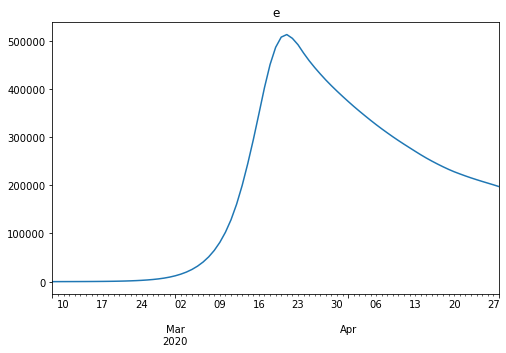

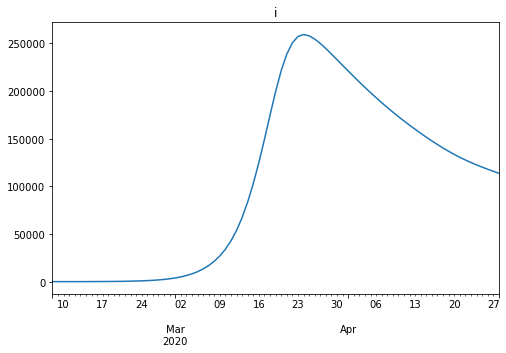

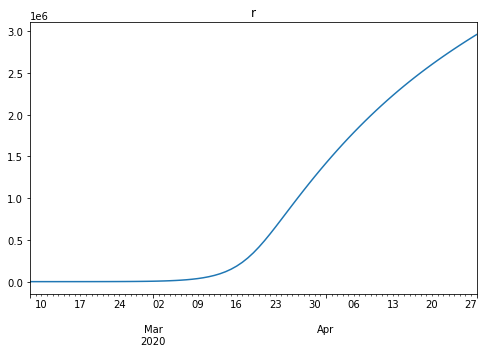

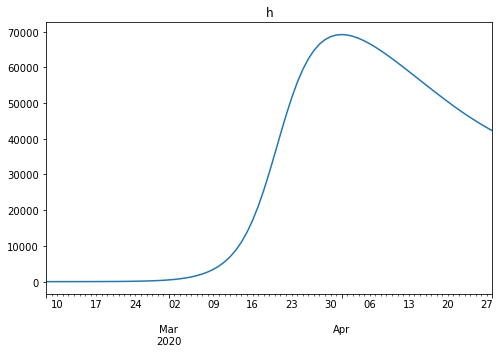

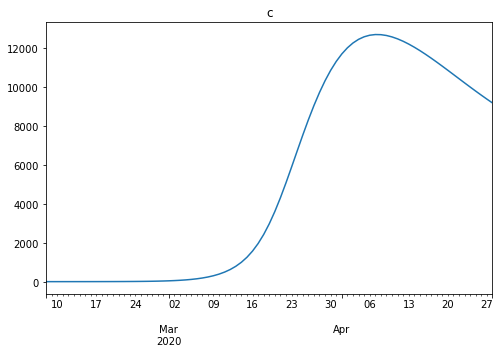

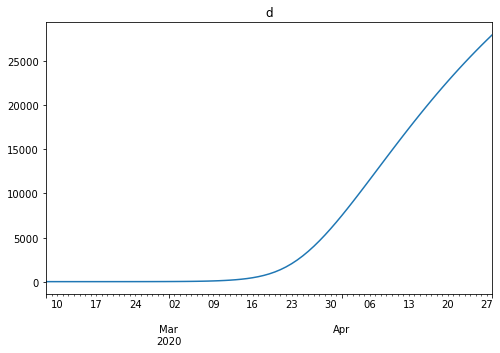

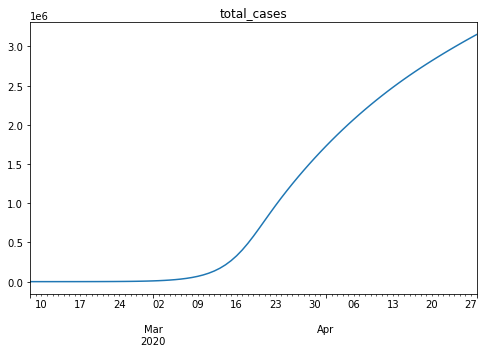

In [153]:
args = PRIOR_MEANS

i_init = 50
i_init /= pop_country
z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
ts = np.arange(float(data.shape[0]))

sim_res = seirhcd_int(z_init, ts, *args)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

### Fake mobility

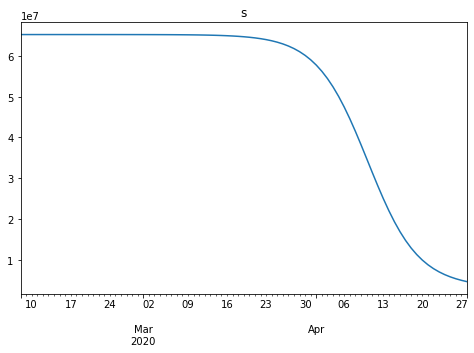

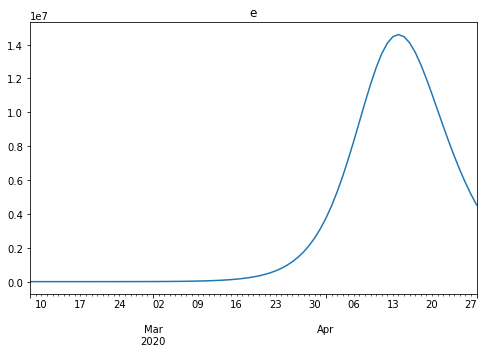

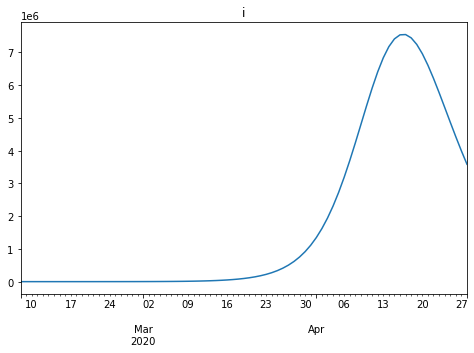

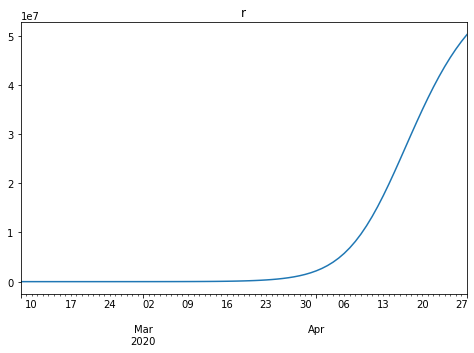

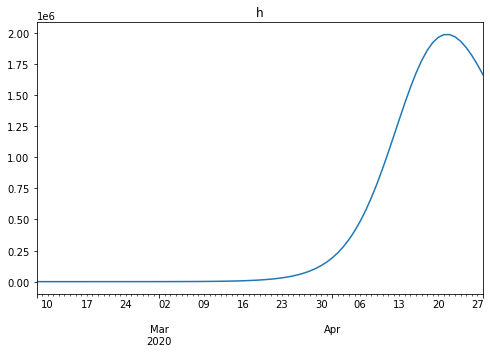

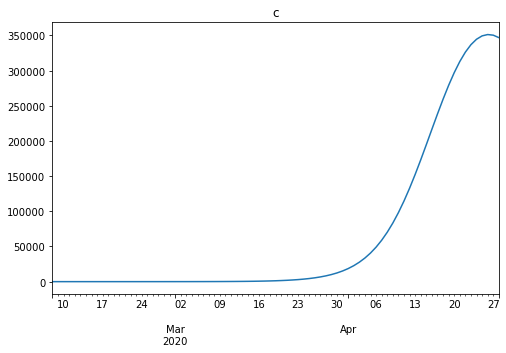

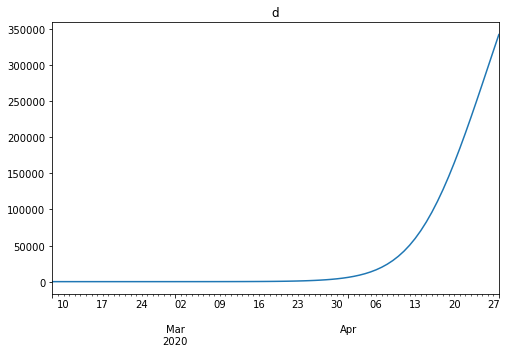

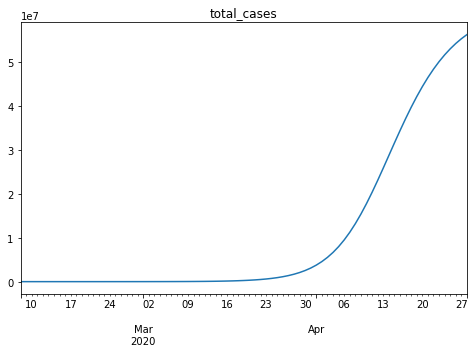

In [155]:
fake_mobility = np.zeros(data.shape[0])
seirhcd_int_fake = build_my_odeint(fake_mobility)
sim_res = seirhcd_int_fake(z_init, ts, *args)

df_res = pd.DataFrame(sim_res) * pop_country
df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
for col in df_res.columns:
    plt.subplots()
    df_res[col].plot(figsize=(8, 5))
    plt.title(col)

## Debug

In [116]:
params = PRIOR_MEANS
N = data.shape[0]

i_init = 50 / pop_country
z_init = np.array([1 - i_init, 0, i_init, 0, 0, 0, 0])
ts = np.arange(float(N))
z = seirhcd_int(z_init, ts, *params)

total_deaths = z[:, -1] * pop_country
daily_deaths = np.hstack((np.array([0.]), np.diff(z[:, -1] * pop_country)))
daily_deaths += 1

daily_critical = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) 
#     daily_critical += BUMP_CRITICAL
daily_critical += 1

daily_hosp = np.hstack((np.array([0]), np.diff(z[:, -3] * pop_country))) 
#     daily_hosp += BUMP_HOSP
daily_hosp += 1

critical = z[:, -2] * pop_country
hosp = z[:, -3] * pop_country

hosp_m1 = np.hstack(([0.],  hosp[:-1]))
critical_m1 = np.hstack(([0.],  critical[:-1]))

bump_hosp = np.min(np.stack([hosp_m1, BUMP_HOSP * np.ones(N)]), axis=0)
bump_critical = np.min(np.stack([critical_m1, BUMP_CRITICAL * np.ones(N)]), axis=0)

nb_samples = 100
samples = dict()
for i in range(nb_samples):
    psi = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i))
    psi_h = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+1))
    psi_c = dist.TruncatedNormal(scale=5.).sample(PRNGKey(5*i+2))
    target_dist = dist.GammaPoisson(
                       np.array([psi_h, psi_c, psi]),
                       rate=np.stack([psi_h / (daily_hosp + bump_hosp), 
                                      psi_c / (daily_critical + bump_critical), 
                                      psi / daily_deaths]
                                    ).T
    )

    reloc = dist.transforms.AffineTransform(
        loc=np.stack([
            - bump_hosp,
            - bump_critical,
            np.zeros(N)]
        ).T,
        scale=1.)

    reloc_target_dist = dist.TransformedDistribution(target_dist, [reloc])

    samples[i] = target_dist.sample(PRNGKey(5*i+3), (nb_samples,))

In [ ]:
for i in 1, 2, 3:
    mu = np.mean(samples[i], axis=0)
    pi = np.percentile(samples[i].astype(float), (10., 90.), axis=0)
    # df = pd.DataFrame(mu).set_index(times)
    # df.columns = 'h c d'.split()
    # # df.eval('cumul_d = d.cumsum()').plot()
    # df.plot()

    plot_hcd_results(mu, pi, data, daily_deaths_true, times)

# Misc

(0.0, 1.0)

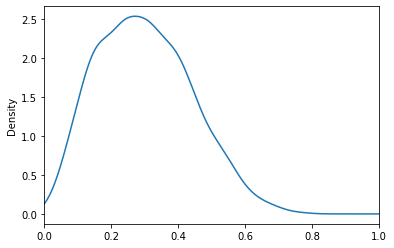

In [246]:
beta = dist.Beta(*reparametrize_beta(0.3, 10))
beta_samples = beta.sample(PRNGKey(0), (1000,))
pd.DataFrame({'samples': beta_samples}).samples.astype(float).plot.kde()
plt.xlim(0, 1)